In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import definitive_dyn_indicators.scripts.data_manager as dm
import os
from tqdm.auto import tqdm
from numba import njit
import lmfit
import joblib
from joblib import Parallel, delayed
import pandas as pd

njobs = os.cpu_count()
print(f'Number of cores: {njobs}')


Number of cores: 20


In [15]:
DATA_DIR = "../../jobs/ground_truth/low_sampling"
SAMPLES = 100

T_GROUND_TRUTH = 100000000
T_NORMALIZATION = 1000
T_DYN_INDICATORS = 1000000

In [16]:
group = (
    0.310,                  # omega_x
    0.320,                  # omega_y
    "sps",                  # modulation_kind
    16.0,                   # epsilon
    0.01,                   # mu
    np.nan,                 # kick amplitude
    np.nan,                 # omega_0
)

group_random = tuple([group[i] if i!=5 else 1e-10 for i in range(len(group))])

X_EXTENTS = [0.0, 0.23]
Y_EXTENTS = [0.0, 0.23]


In [17]:
data = dm.data_manager(data_dir=DATA_DIR)

data.henon_config["samples"] = SAMPLES
data.henon_config["x_extents"] = X_EXTENTS
data.henon_config["y_extents"] = Y_EXTENTS

data.henon_config["t_base_2"] = np.array([], dtype=int)
data.henon_config["t_base"] = np.array([], dtype=int)
data.henon_config["t_base_10"] = np.logspace(
    int(np.log10(T_NORMALIZATION)),
    int(np.log10(T_GROUND_TRUTH)),
    int(np.log10(T_GROUND_TRUTH)) - int(np.log10(T_NORMALIZATION)) + 1,
    base=10, dtype=int)
data.henon_config["t_linear"] = np.array([], dtype=int)

data.henon_config = dm.refresh_henon_config(data.henon_config)

config = data.get_config()
extents = config["x_extents"] + config["y_extents"]
samples = config["samples"]

times = np.asarray(data.get_times())


In [18]:
full_lyapunov = data.fast_lyapunov_indicator(group)

Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking lyapunov!


100%|██████████| 6/6 [00:00<00:00, 449.04it/s]


In [19]:
with data.get_file_from_group(group, "none", "lyapunov") as f:
    stability = f["steps"][:]
stability = stability[:len(stability)//2]


Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking lyapunov!


In [20]:
data_minor = dm.data_manager(
    data_dir=os.path.join(DATA_DIR, "10_6"))

data_minor.henon_config["samples"] = SAMPLES
data_minor.henon_config["x_extents"] = X_EXTENTS
data_minor.henon_config["y_extents"] = Y_EXTENTS

data_minor.henon_config["t_base_2"] = np.array([], dtype=int)
data_minor.henon_config["t_base"] = np.arange(
    T_NORMALIZATION, T_DYN_INDICATORS + T_NORMALIZATION, T_NORMALIZATION, dtype=int)

data_minor.henon_config["t_base_10"] = np.array([], dtype=int)
data_minor.henon_config["t_linear"] = np.array([], dtype=int)

data_minor.henon_config = dm.refresh_henon_config(data_minor.henon_config)


In [21]:
times_minor = np.asarray(data_minor.get_times())


In [22]:
gali = data_minor.global_alignment_index(group)


Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking gali!


100%|██████████| 1000/1000 [00:01<00:00, 914.24it/s]


In [23]:
sali = data_minor.smallest_alignment_index(group)


Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking sali!


100%|██████████| 1000/1000 [00:01<00:00, 762.79it/s]


In [24]:
lyapunov = data_minor.fast_lyapunov_indicator(group)


Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking lyapunov!


100%|██████████| 1000/1000 [00:01<00:00, 891.16it/s]


In [25]:
ortho_lyap_max, ortho_lyap_avg = data_minor.orthogonal_lyapunov_indicator(group)

Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking orthogonal_lyapunov!


100%|██████████| 1000/1000 [00:06<00:00, 155.01it/s]


In [27]:
reverse = data_minor.reversibility_error(group)

Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking track_and_reverse!
Generating (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) on the fly
creating gpu tracker
Creating henon_ox_0.31_oy_0.32_modulation_sps_eps_16.0_mu_0.01_kmod_nan_o0_nan_disp_none_data_track_and_reverse.hdf5


  2%|▏         | 23/1000 [00:04<05:35,  2.91it/s]

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


100%|██████████| 1000/1000 [1:01:27<00:00,  3.69s/it]


Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking track_and_reverse!


100%|██████████| 1000/1000 [00:04<00:00, 213.16it/s]


In [ ]:
reverse_kick = data_minor.reversibility_error(group_random)

Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, 1e-10, nan) with displacement none and tracking track_and_reverse!
Generating (0.31, 0.32, 'sps', 16.0, 0.01, 1e-10, nan) on the fly
creating gpu tracker
Creating henon_ox_0.31_oy_0.32_modulation_sps_eps_16.0_mu_0.01_kmod_nan_o0_nan_disp_none_data_track_and_reverse.hdf5


  6%|▌         | 60/1000 [00:13<03:24,  4.60it/s]

Keyboard interrupt


KeyboardInterrupt: 

In [29]:
data_tune = dm.data_manager(
    data_dir=os.path.join(DATA_DIR, "10_6"))

data_tune.henon_config["samples"] = SAMPLES
data_tune.henon_config["x_extents"] = X_EXTENTS
data_tune.henon_config["y_extents"] = Y_EXTENTS

# find the closest power of 2 to T_DYN_INDICATORS
t_tune_pow = np.ceil(np.log2(T_DYN_INDICATORS))
t_tune_min = 4

data_tune.henon_config["t_base_2"] = 2 ** np.arange(t_tune_min, t_tune_pow + 1, dtype=int)
data_tune.henon_config["t_base"] = np.array([], dtype=int)
data_tune.henon_config["t_base_10"] = np.array([], dtype=int)
data_tune.henon_config["t_linear"] = np.array([], dtype=int)

data_tune.henon_config = dm.refresh_henon_config(data_tune.henon_config)

times_tune = np.asarray(data_tune.get_times())


In [30]:
tunes = data_tune.birkhoff_tunes(group)

Getting file for group (0.31, 0.32, 'sps', 16.0, 0.01, nan, nan) with displacement none and tracking birkhoff_tunes!


In [ ]:
assert(False)

# PLOTS

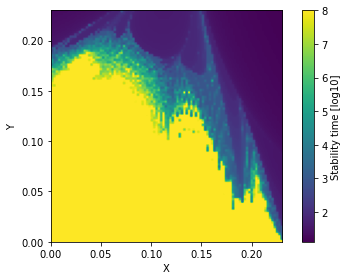

In [31]:
fig, ax = plt.subplots(1, 1)
map = ax.imshow(np.log10(stability).reshape(samples, samples), origin="lower", extent=extents)
plt.colorbar(map, label="Stability time [log10]")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()

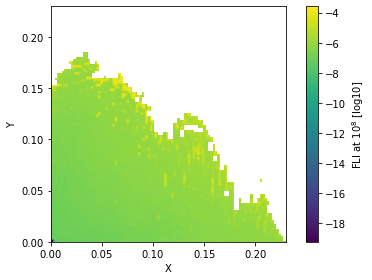

In [39]:
fig, ax = plt.subplots(1, 1)
map = ax.imshow(np.log10(full_lyapunov[T_GROUND_TRUTH].to_numpy()).reshape(samples, samples), origin="lower", extent=extents)
plt.colorbar(map, label="FLI at $10^8$ [log10]")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.tight_layout()

In [32]:
threshold = -5.7


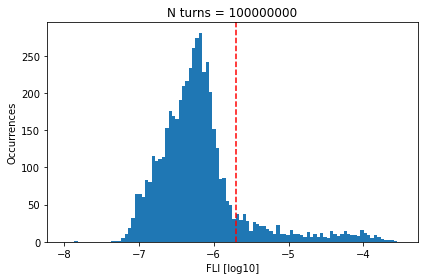

In [33]:
fig, ax = plt.subplots(1, 1)
ax.hist(
    np.log10(full_lyapunov[T_GROUND_TRUTH].to_numpy()), bins=100, range=(-8, -3.5)
)
ax.axvline(threshold, color="r", linestyle="--")
ax.set_xlabel("FLI [log10]")
ax.set_ylabel("Occurrences")
ax.set_title(f"N turns = {T_GROUND_TRUTH}")
plt.tight_layout()

/tmp/ipykernel_31755/3389418852.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov[T_NORMALIZATION].to_numpy()), bins=100
/tmp/ipykernel_31755/3389418852.py:11: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov[T_DYN_INDICATORS].to_numpy()), bins=100


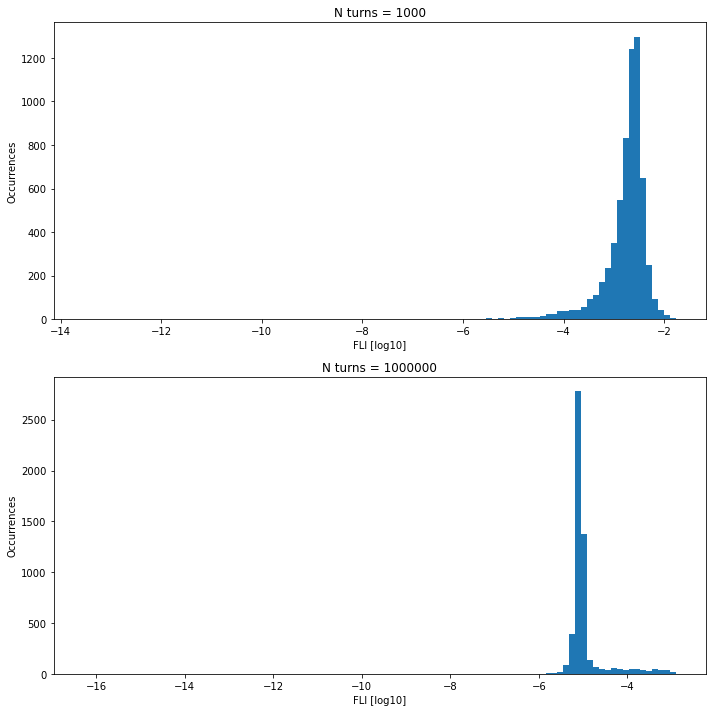

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(lyapunov[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("FLI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[1].hist(
    np.log10(lyapunov[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("FLI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


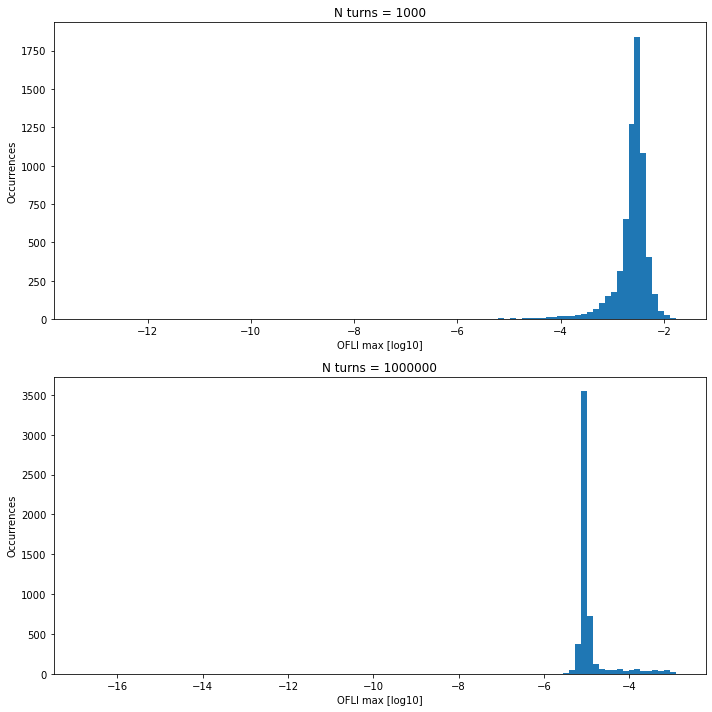

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(ortho_lyap_max[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("OFLI max [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[1].hist(
    np.log10(ortho_lyap_max[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("OFLI max [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


/tmp/ipykernel_31755/308094567.py:11: RuntimeWarning: invalid value encountered in log10
  np.log10(ortho_lyap_avg[T_DYN_INDICATORS].to_numpy()), bins=100


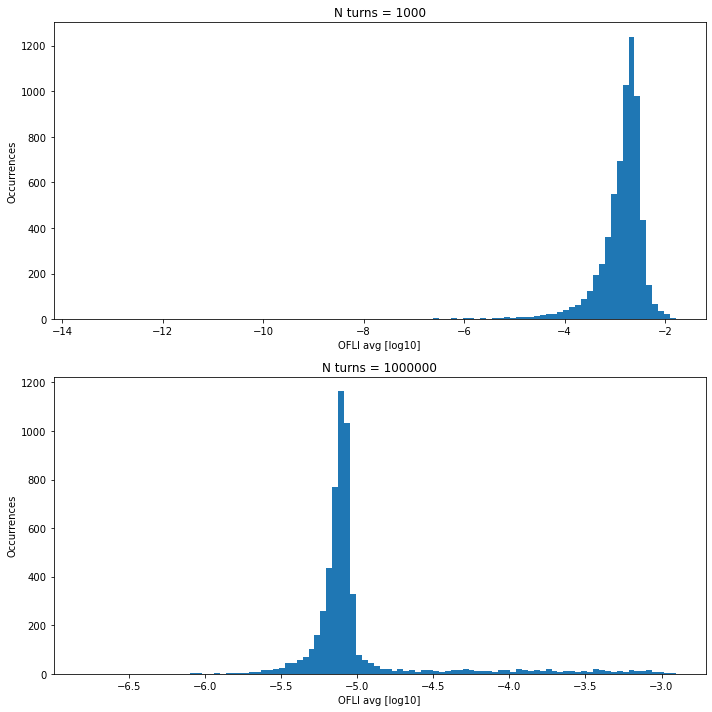

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(ortho_lyap_avg[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("OFLI avg [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[1].hist(
    np.log10(ortho_lyap_avg[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("OFLI avg [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


/tmp/ipykernel_31755/610851619.py:10: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(sali[T_DYN_INDICATORS].to_numpy())


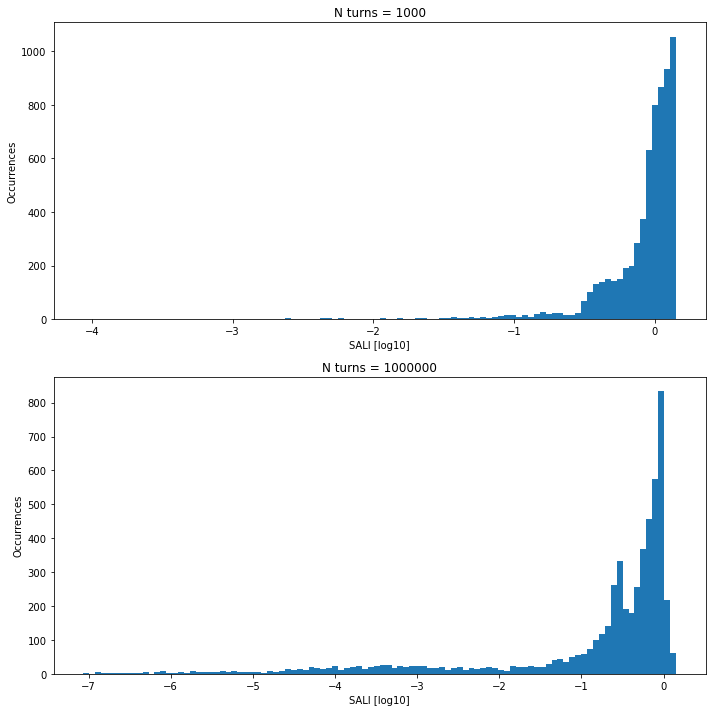

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(sali[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("SALI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

d = np.log10(sali[T_DYN_INDICATORS].to_numpy())
d = d[~np.isinf(d)]
axs[1].hist(d, bins=100)
axs[1].set_xlabel("SALI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


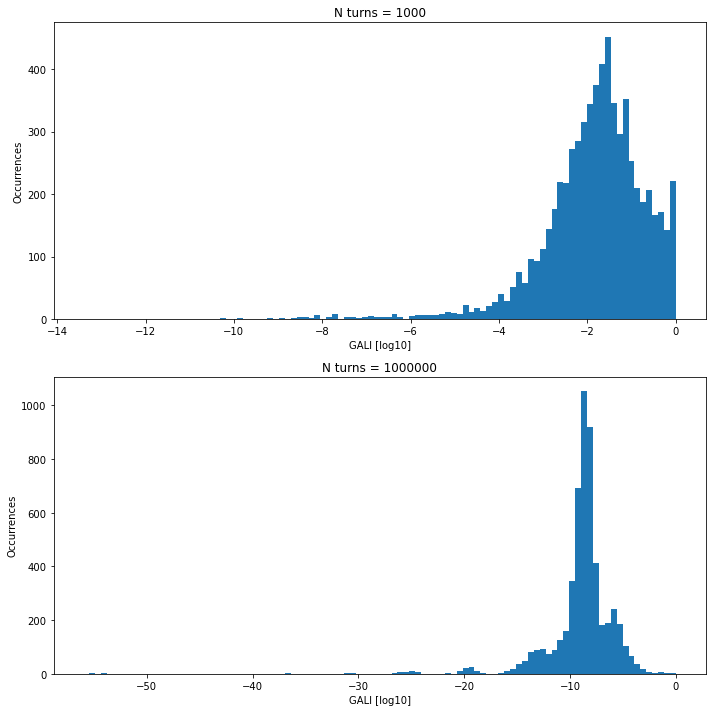

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(gali[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("GALI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[1].hist(
    np.log10(gali[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("GALI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


/tmp/ipykernel_31755/4219930325.py:3: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(reverse[T_NORMALIZATION].to_numpy())
/tmp/ipykernel_31755/4219930325.py:10: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(reverse[T_DYN_INDICATORS].to_numpy())


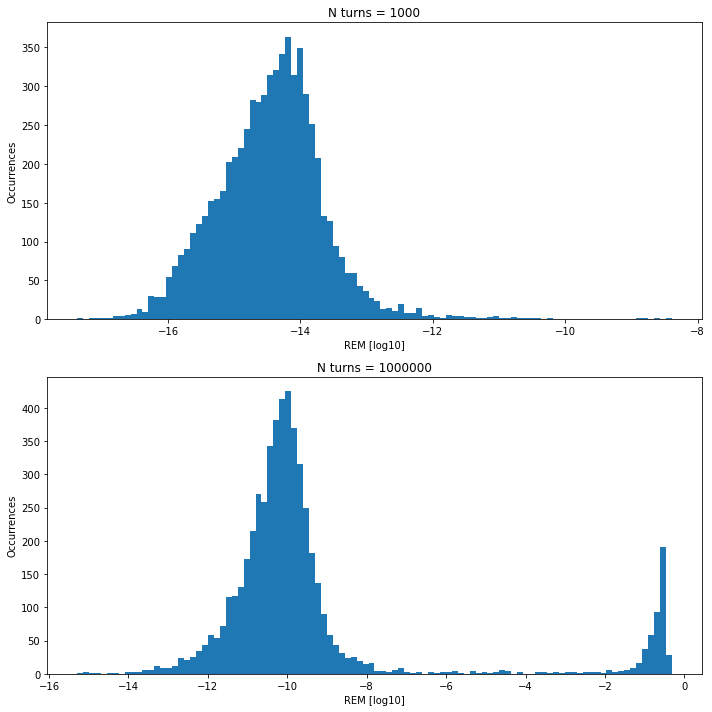

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

t = np.log10(reverse[T_NORMALIZATION].to_numpy())
t = t[~np.isinf(t)]
axs[0].hist(t, bins=100)
axs[0].set_xlabel("REM [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

t = np.log10(reverse[T_DYN_INDICATORS].to_numpy())
t = t[~np.isinf(t)]
axs[1].hist(t, bins=100)
axs[1].set_xlabel("REM [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


NameError: name 'reverse_kick' is not defined

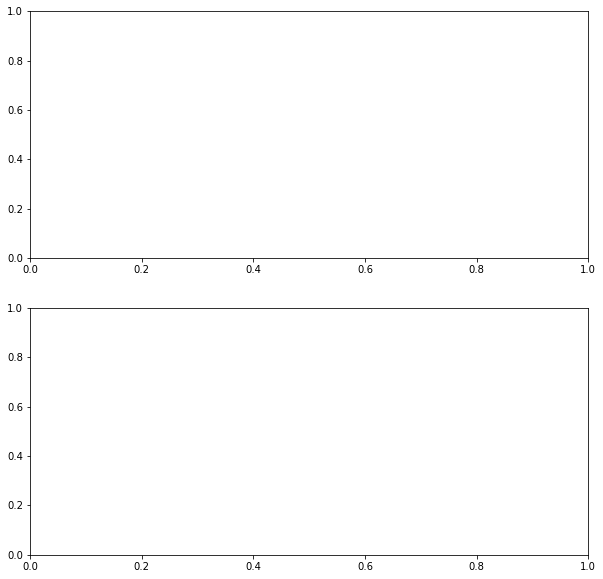

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(reverse_kick[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("RE [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[1].hist(
    np.log10(reverse_kick[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("RE [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

plt.tight_layout()


In [ ]:
tunes

,8,16,32,64,128,256,512,1024,2048,4096,8192,16384,32768,65536,131072,262144
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000126,0.000319,0.000538,0.000601,0.000726,0.000560,0.00039,0.000272,0.000031,0.000005,2.268528e-08,1.006020e-10,1.202372e-13,3.885781e-15,1.332268e-15,9.436896e-15
2,0.000158,0.000329,0.000530,0.000600,0.000726,0.000560,0.00039,0.000272,0.000031,0.000005,2.268607e-08,1.006083e-10,9.359180e-14,1.099121e-14,4.218847e-15,7.438494e-15
3,0.000191,0.000340,0.000522,0.000599,0.000726,0.000560,0.00039,0.000272,0.000031,0.000005,2.268740e-08,1.006178e-10,1.170175e-13,1.176836e-14,1.387779e-14,2.187139e-14
4,0.000226,0.000351,0.000514,0.000599,0.000726,0.000561,0.00039,0.000272,0.000031,0.000005,2.268926e-08,1.006181e-10,1.156852e-13,3.996803e-15,5.551115e-16,1.232348e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_31755/3731449959.py:3: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(tunes[times_tune[0]].to_numpy())
/tmp/ipykernel_31755/3731449959.py:10: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(tunes[times_tune[-3]].to_numpy())


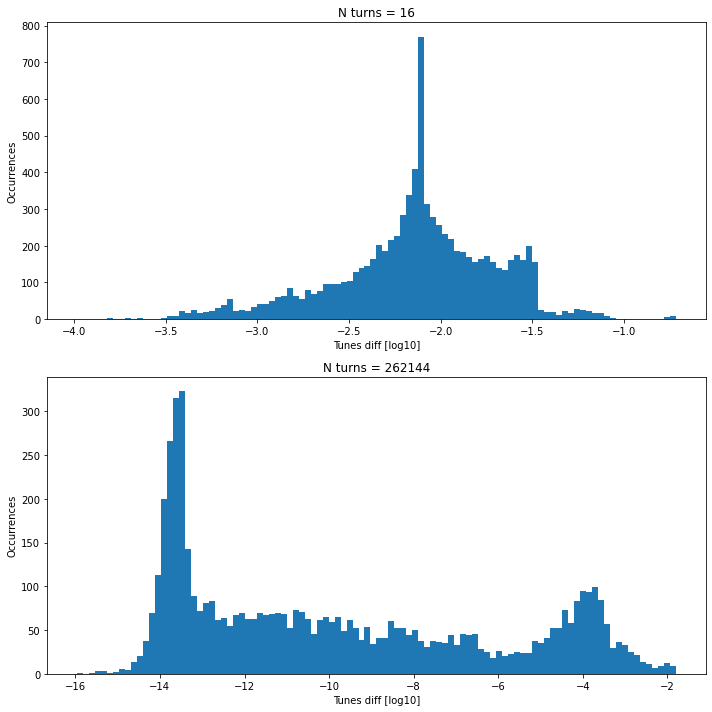

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

t = np.log10(tunes[times_tune[0]].to_numpy())
t = t[~np.isinf(t)]
axs[0].hist(t, bins=100)
axs[0].set_xlabel("Tunes diff [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {times_tune[0]}")

t = np.log10(tunes[times_tune[-3]].to_numpy())
t = t[~np.isinf(t)]
axs[1].hist(t, bins=100)
axs[1].set_xlabel("Tunes diff [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {times_tune[-3]}")

plt.tight_layout()


# Benchmarks

In [34]:
nan_mask = stability > 100
ground_truth =  np.asarray(np.logical_and(
    stability >= T_GROUND_TRUTH,
    np.log10(full_lyapunov[T_GROUND_TRUTH].to_numpy()) <= threshold
), dtype=float)

ground_truth[~nan_mask] = np.nan

stable_mask = np.asarray(stability >= T_GROUND_TRUTH, dtype=float)
stable_mask[~nan_mask] = np.nan



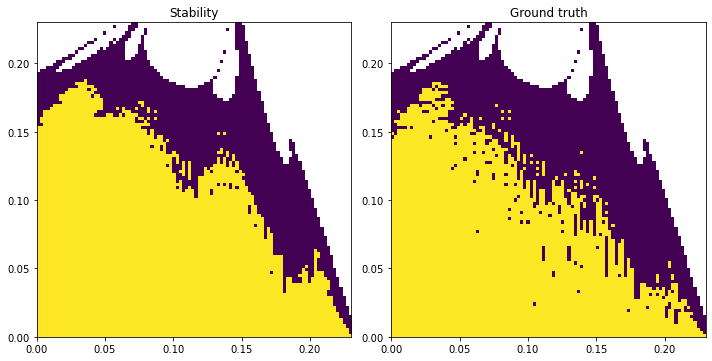

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(stable_mask.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("Stability")
axs[1].set_title("Ground truth")

plt.tight_layout()

/tmp/ipykernel_31755/2704915426.py:3: RuntimeWarning: divide by zero encountered in log10
  tmp = np.log10(sali[1000000].to_numpy())


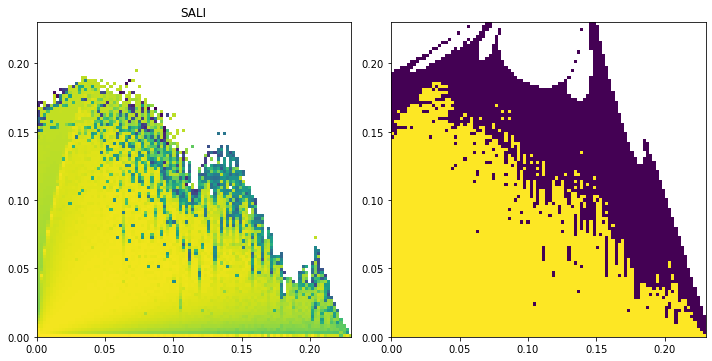

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tmp = np.log10(sali[1000000].to_numpy())
tmp[np.isinf(tmp)] = np.nan
axs[0].imshow(tmp.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("SALI")

plt.tight_layout()

/tmp/ipykernel_10452/3059474104.py:3: RuntimeWarning: divide by zero encountered in log10
  tmp = np.log10(tunes[times_tune[-3]].to_numpy())


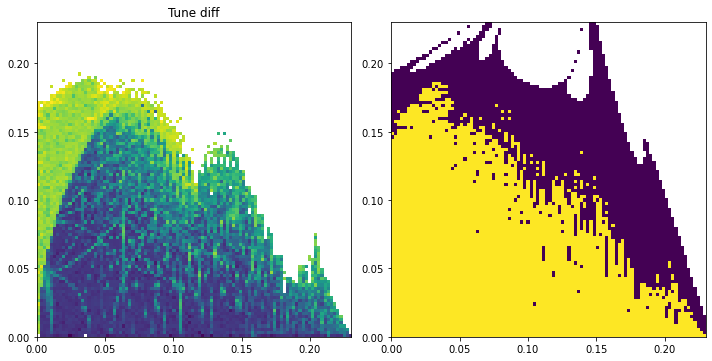

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tmp = np.log10(tunes[times_tune[-3]].to_numpy())
tmp[np.isinf(tmp)] = np.nan
axs[0].imshow(tmp.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("Tune diff")

plt.tight_layout()

/tmp/ipykernel_31755/2246844411.py:3: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(lyapunov[1000000].to_numpy())


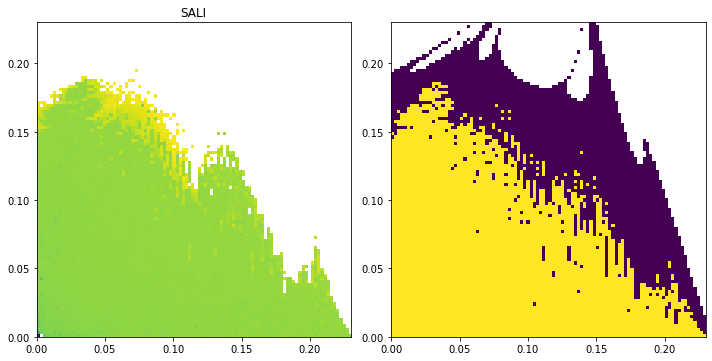

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tmp = np.log10(lyapunov[1000000].to_numpy())
tmp[np.isinf(tmp)] = np.nan
axs[0].imshow(tmp.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("SALI")

plt.tight_layout()

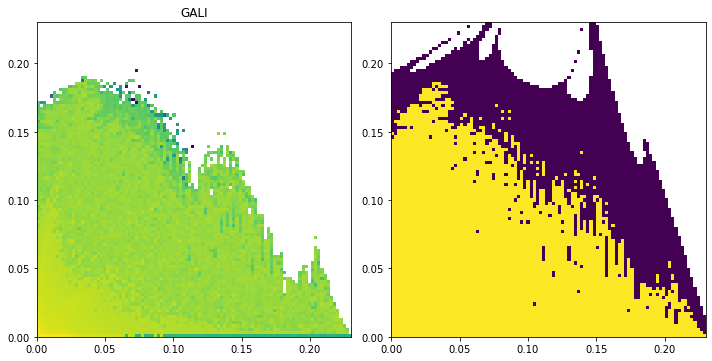

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tmp = np.log10(gali[1000000].to_numpy())
tmp[np.isinf(tmp)] = np.nan
axs[0].imshow(tmp.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("GALI")

plt.tight_layout()

/tmp/ipykernel_31755/1406852243.py:3: RuntimeWarning: divide by zero encountered in log10
  tmp = np.log10(reverse[1000000].to_numpy())


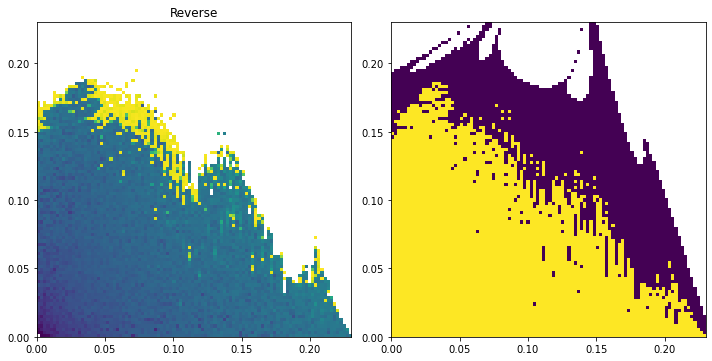

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

tmp = np.log10(reverse[1000000].to_numpy())
tmp[np.isinf(tmp)] = np.nan
axs[0].imshow(tmp.reshape(samples, samples), extent=extents, origin="lower")
axs[1].imshow(ground_truth.reshape(samples, samples), extent=extents, origin="lower")

axs[0].set_title("Reverse")

plt.tight_layout()

In [ ]:
values_lyap = []

for t in tqdm(times_minor):
    values_lyap.append(dm.get_full_comparison(
        np.log10(lyapunov[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_lyap = np.asarray([v["accuracy_best_val"] for v in values_lyap])
th_chosen_lyap = np.asarray([v["threshold"] for v in values_lyap])

ac_best_lyap = np.asarray([v["accuracy_best"] for v in values_lyap])
ac_chosen_lyap = np.asarray([v["accuracy_threshold"] for v in values_lyap])


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/si

In [ ]:
values_olyap_max = []

for t in tqdm(times_minor):
    values_olyap_max.append(dm.get_full_comparison(
        np.log10(ortho_lyap_max[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_olyap_max = np.asarray([v["accuracy_best_val"] for v in values_olyap_max])
th_chosen_olyap_max = np.asarray([v["threshold"] for v in values_olyap_max])

ac_best_olyap_max = np.asarray([v["accuracy_best"] for v in values_olyap_max])
ac_chosen_olyap_max = np.asarray([v["accuracy_threshold"] for v in values_olyap_max])


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/si

In [ ]:
values_olyap_avg = []

for t in tqdm(times_minor):
    values_olyap_avg.append(dm.get_full_comparison(
        np.log10(ortho_lyap_avg[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_olyap_avg = np.asarray([v["accuracy_best_val"] for v in values_olyap_avg])
th_chosen_olyap_avg = np.asarray([v["threshold"] for v in values_olyap_avg])

ac_best_olyap_avg = np.asarray([v["accuracy_best"] for v in values_olyap_avg])
ac_chosen_olyap_avg = np.asarray([v["accuracy_threshold"] for v in values_olyap_avg])


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/si

In [ ]:
values_sali = []

for t in tqdm(times_minor):
    values_sali.append(dm.get_full_comparison(
        np.log10(sali[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=True,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_sali = np.asarray([v["accuracy_best_val"] for v in values_sali])
th_chosen_sali = np.asarray([v["threshold"] for v in values_sali])

ac_best_sali = np.asarray([v["accuracy_best"] for v in values_sali])
ac_chosen_sali = np.asarray([v["accuracy_threshold"] for v in values_sali])


  0%|          | 0/1000 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3

In [ ]:
values_gali = []

for t in tqdm(times_minor):
    values_gali.append(dm.get_full_comparison(
        np.log10(gali[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=True,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_gali = np.asarray([v["accuracy_best_val"] for v in values_gali])
th_chosen_gali = np.asarray([v["threshold"] for v in values_gali])

ac_best_gali = np.asarray([v["accuracy_best"] for v in values_gali])
ac_chosen_gali = np.asarray([v["accuracy_threshold"] for v in values_gali])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
values_reverse = []

for t in tqdm(times_minor):
    values_reverse.append(dm.get_full_comparison(
        np.log10(reverse[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_reverse = np.asarray([v["accuracy_best_val"] for v in values_reverse])
th_chosen_reverse = np.asarray([v["threshold"] for v in values_reverse])

ac_best_reverse = np.asarray([v["accuracy_best"] for v in values_reverse])
ac_chosen_reverse = np.asarray([v["accuracy_threshold"] for v in values_reverse])

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3

In [ ]:
values_reverse_kick = []

for t in tqdm(times_minor):
    values_reverse_kick.append(dm.get_full_comparison(
        np.log10(reverse_kick[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_reverse_kick = np.asarray([v["accuracy_best_val"] for v in values_reverse_kick])
th_chosen_reverse_kick = np.asarray([v["threshold"] for v in values_reverse_kick])

ac_best_reverse_kick = np.asarray([v["accuracy_best"] for v in values_reverse_kick])
ac_chosen_reverse_kick = np.asarray([v["accuracy_threshold"] for v in values_reverse_kick])


In [ ]:
values_tunes = []

for t in tqdm(times_tune[:-2]):
    values_tunes.append(dm.get_full_comparison(
        np.log10(tunes[t]).to_numpy(),
        ground_truth == 1,
        stable_if_higher=False,
        naive_data=stability,
        naive_thresh_min=100,
        naive_thresh_max=t
    ))

th_best_tunes = np.asarray([v["accuracy_best_val"] for v in values_tunes])
th_chosen_tunes = np.asarray([v["threshold"] for v in values_tunes])

ac_best_tunes = np.asarray([v["accuracy_best"] for v in values_tunes])
ac_chosen_tunes = np.asarray([v["accuracy_threshold"] for v in values_tunes])


  0%|          | 0/15 [00:00<?, ?it/s]

/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/HPC/camontan/anaconda3/lib/python3

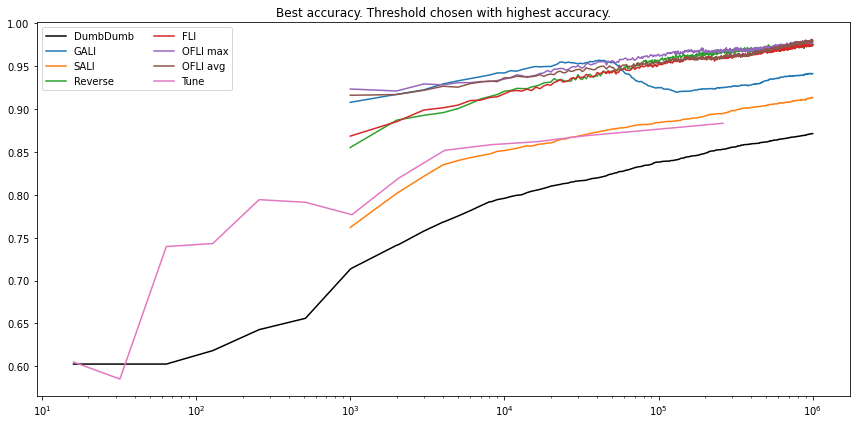

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

all_times = np.concatenate([times_minor, times_tune[:-2]])
all_times = np.unique(all_times)

valid_particles = np.count_nonzero(~np.isnan(ground_truth))
bogus_value = np.array([
    np.count_nonzero(stability[~np.isnan(ground_truth)] < t) + np.count_nonzero(ground_truth==1) for t in all_times
])

ax.plot(all_times, bogus_value / valid_particles, label="DumbDumb", color="black")

ax.plot(times_minor, ac_best_gali, label="GALI")
ax.plot(times_minor, ac_best_sali, label="SALI")
ax.plot(times_minor, ac_best_reverse, label="Reverse")
ax.plot(times_minor, ac_best_lyap, label="FLI")
ax.plot(times_minor, ac_best_olyap_max, label="OFLI max")
ax.plot(times_minor, ac_best_olyap_avg, label="OFLI avg")
ax.plot(times_tune[:-2], ac_best_tunes, label="Tune")

ax.legend(ncol=2)
ax.set_xscale("log")

ax.set_title("Best accuracy. Threshold chosen with highest accuracy.")
plt.tight_layout()

/tmp/ipykernel_31755/3826716649.py:4: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov[T_NORMALIZATION].to_numpy()), bins=100
/tmp/ipykernel_31755/3826716649.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(lyapunov[T_DYN_INDICATORS].to_numpy()), bins=100


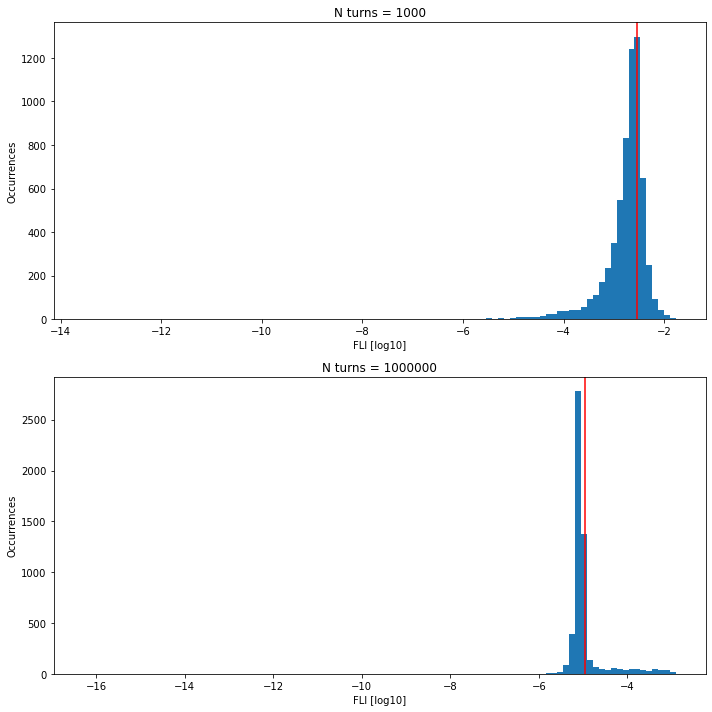

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(lyapunov[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("FLI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_lyap[0], color="red", label="Threshold")

axs[1].hist(
    np.log10(lyapunov[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("FLI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_lyap[-1], color="red", label="Threshold")

plt.tight_layout()


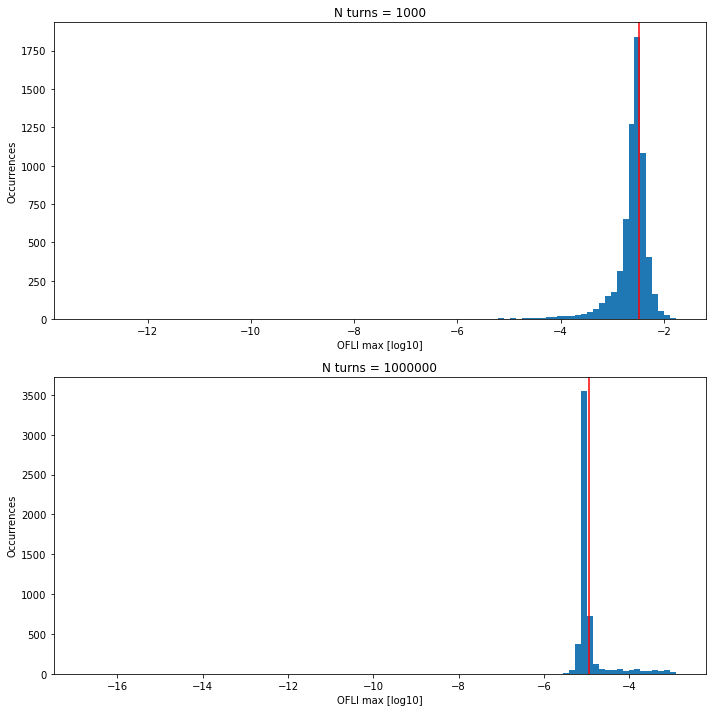

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(ortho_lyap_max[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("OFLI max [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_olyap_max[0], color="red", label="Threshold")

axs[1].hist(
    np.log10(ortho_lyap_max[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("OFLI max [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_olyap_max[-1], color="red", label="Threshold")

plt.tight_layout()


/tmp/ipykernel_31755/3812531984.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(ortho_lyap_avg[T_DYN_INDICATORS].to_numpy()), bins=100


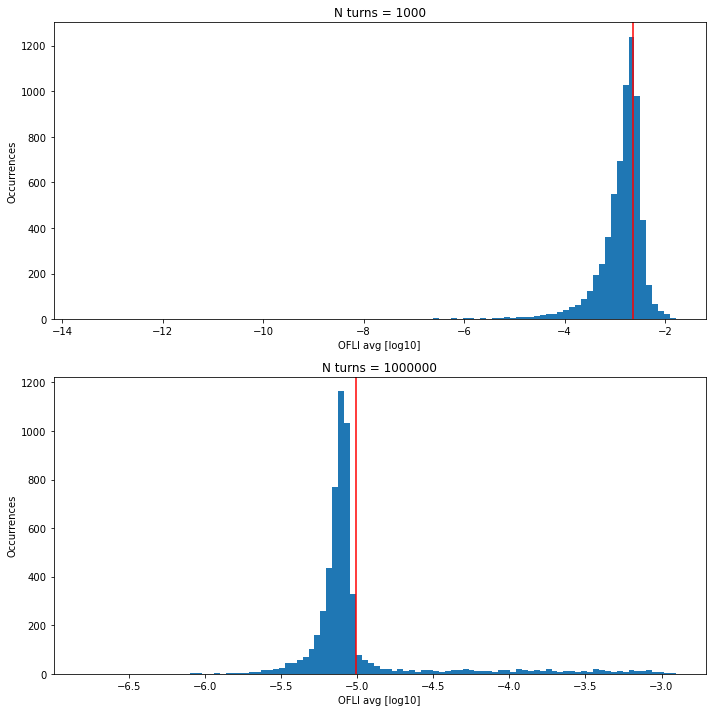

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(ortho_lyap_avg[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("OFLI avg [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_olyap_avg[0], color="red", label="Threshold")

axs[1].hist(
    np.log10(ortho_lyap_avg[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("OFLI avg [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_olyap_avg[-1], color="red", label="Threshold")

plt.tight_layout()


/tmp/ipykernel_31755/3633122644.py:12: RuntimeWarning: divide by zero encountered in log10
  d = np.log10(sali[T_DYN_INDICATORS].to_numpy())


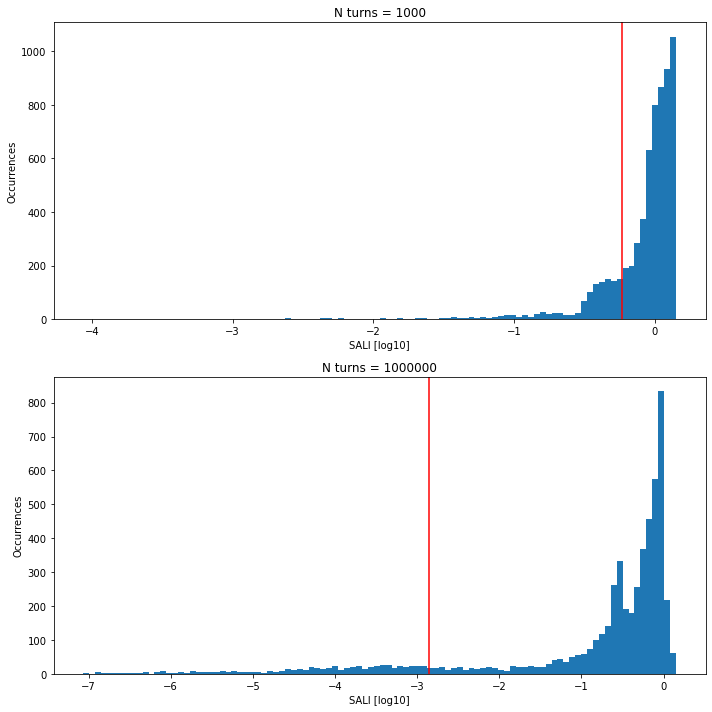

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(sali[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("SALI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_sali[0], color="red", label="Threshold")

d = np.log10(sali[T_DYN_INDICATORS].to_numpy())
d = d[~np.isinf(d)]
axs[1].hist(d, bins=100)
axs[1].set_xlabel("SALI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_sali[-1], color="red", label="Threshold")

plt.tight_layout()


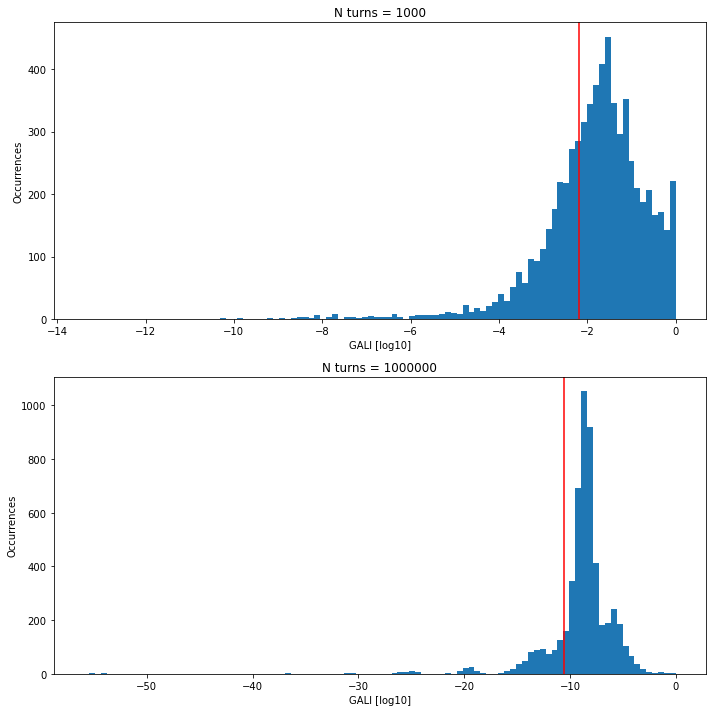

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].hist(
    np.log10(gali[T_NORMALIZATION].to_numpy()), bins=100
)
axs[0].set_xlabel("GALI [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_gali[0], color="red", label="Threshold")

axs[1].hist(
    np.log10(gali[T_DYN_INDICATORS].to_numpy()), bins=100
)
axs[1].set_xlabel("GALI [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_gali[-1], color="red", label="Threshold")

plt.tight_layout()


/tmp/ipykernel_31755/3284841709.py:3: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(reverse[T_NORMALIZATION].to_numpy())
/tmp/ipykernel_31755/3284841709.py:12: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(reverse[T_DYN_INDICATORS].to_numpy())


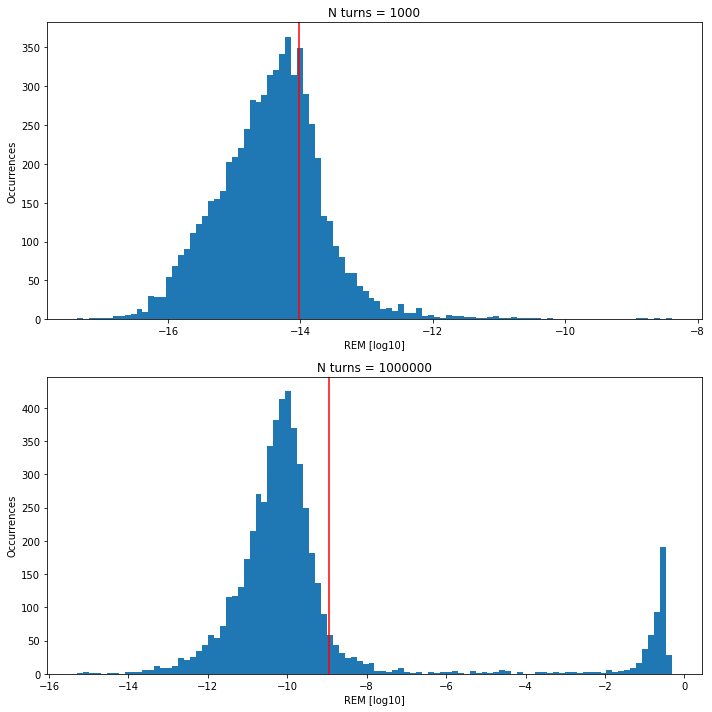

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

t = np.log10(reverse[T_NORMALIZATION].to_numpy())
t = t[~np.isinf(t)]
axs[0].hist(t, bins=100)
axs[0].set_xlabel("REM [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {T_NORMALIZATION}")

axs[0].axvline(th_best_reverse[0], color="red", label="Threshold")

t = np.log10(reverse[T_DYN_INDICATORS].to_numpy())
t = t[~np.isinf(t)]
axs[1].hist(t, bins=100)
axs[1].set_xlabel("REM [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {T_DYN_INDICATORS}")

axs[1].axvline(th_best_reverse[-1], color="red", label="Threshold")

plt.tight_layout()


/tmp/ipykernel_31755/2825898946.py:3: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(tunes[times_tune[0]].to_numpy())
/tmp/ipykernel_31755/2825898946.py:12: RuntimeWarning: divide by zero encountered in log10
  t = np.log10(tunes[times_tune[-3]].to_numpy())


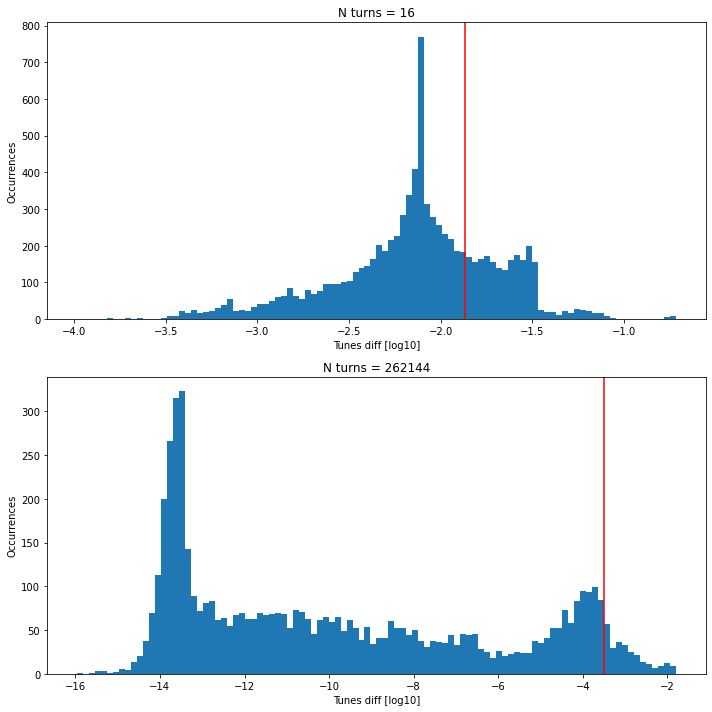

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

t = np.log10(tunes[times_tune[0]].to_numpy())
t = t[~np.isinf(t)]
axs[0].hist(t, bins=100)
axs[0].set_xlabel("Tunes diff [log10]")
axs[0].set_ylabel("Occurrences")
axs[0].set_title(f"N turns = {times_tune[0]}")

axs[0].axvline(th_best_tunes[0], color="red", label="Threshold")

t = np.log10(tunes[times_tune[-3]].to_numpy())
t = t[~np.isinf(t)]
axs[1].hist(t, bins=100)
axs[1].set_xlabel("Tunes diff [log10]")
axs[1].set_ylabel("Occurrences")
axs[1].set_title(f"N turns = {times_tune[-3]}")

axs[1].axvline(th_best_tunes[-1], color="red", label="Threshold")

plt.tight_layout()
